In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/state-farm-distracted-driver-detection


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import Inception_V3_Weights
from torch import nn, optim

# Paths
base_path = "/kaggle/input/state-farm-distracted-driver-detection"
train_dir = os.path.join(base_path, "imgs/train")

# Transforms (299x299 required for Inception)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model setup: Inception v3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model = models.inception_v3(weights=weights, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 10)  # optional but recommended
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Epoch {epoch+1}: Loss={running_loss:.3f}, Train Acc={train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    val_acc = 100 * val_correct / len(val_dataset)
    print(f"Validation Acc: {val_acc:.2f}%")

# Save model
torch.save(model.state_dict(), "inceptionv3_driver_distraction.pth")


Epoch 1: Loss=146.440, Train Acc=93.46%
Validation Acc: 99.46%
Epoch 2: Loss=15.678, Train Acc=99.31%
Validation Acc: 99.31%
Epoch 3: Loss=8.254, Train Acc=99.63%
Validation Acc: 99.40%
Epoch 4: Loss=5.746, Train Acc=99.79%
Validation Acc: 99.54%
Epoch 5: Loss=7.677, Train Acc=99.62%
Validation Acc: 99.80%


/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


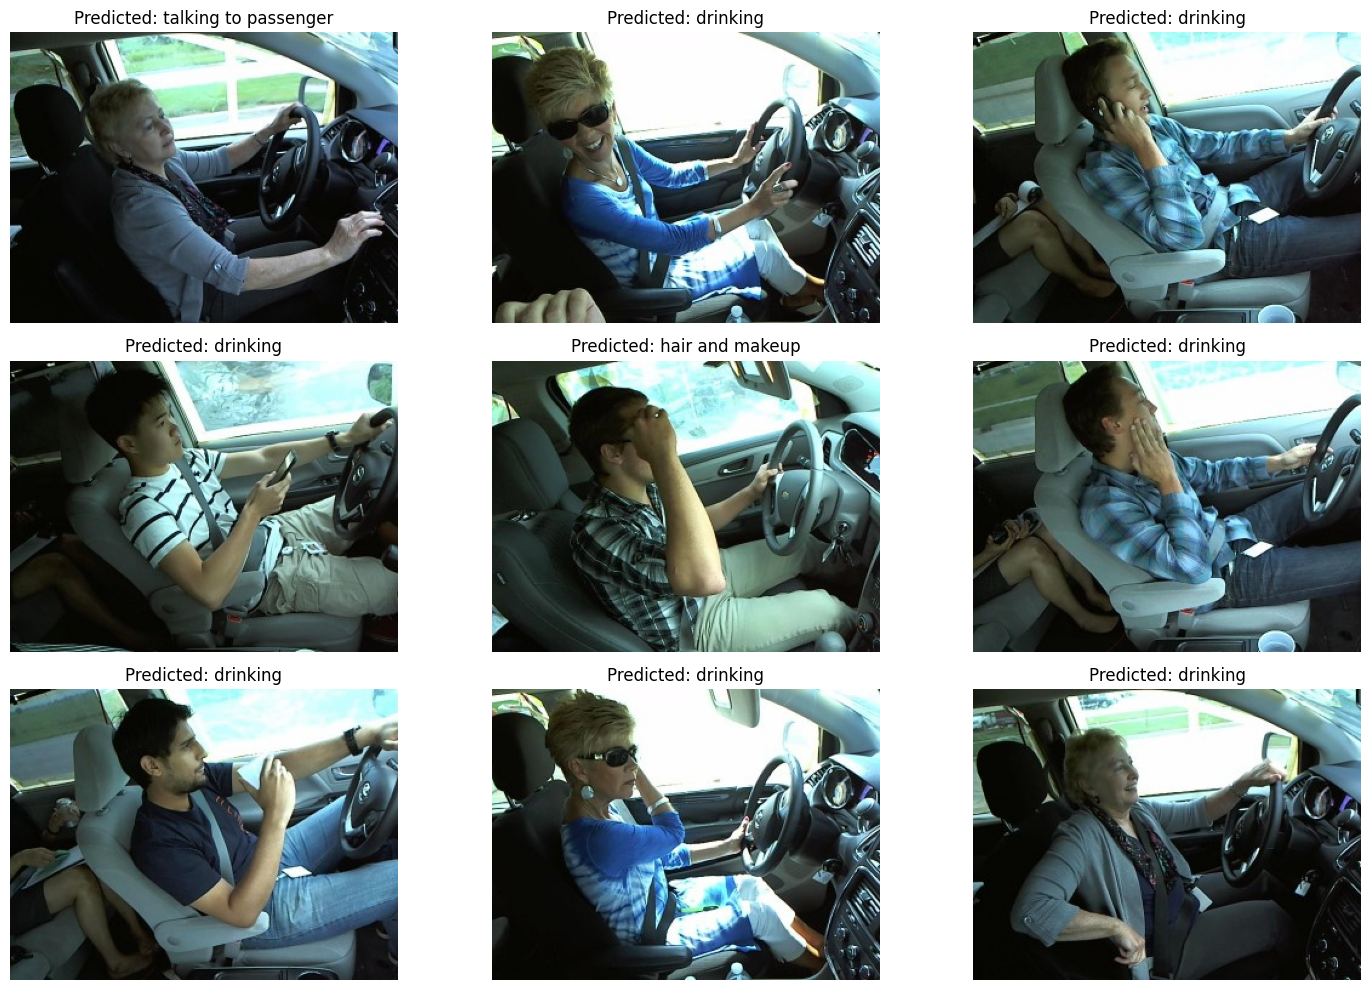

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from torchvision.models import Inception_V3_Weights
import numpy as np
import torch
import os

# Test path
test_dir = os.path.join(base_path, "imgs/test")
test_images = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

# Load model
weights = Inception_V3_Weights.DEFAULT
model = models.inception_v3(weights=None, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 10)
model.load_state_dict(torch.load("inceptionv3_driver_distraction.pth"))
model.eval().to(device)

# Transform for Inception v3 (299x299)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Class names
class_names = [
    'safe driving', 'texting - right', 'talking on the phone - right',
    'texting - left', 'talking on the phone - left', 'operating the radio',
    'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Display predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    img_path = os.path.join(test_dir, test_images[i])
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, tuple):  # Inception returns (main_output, aux_output)
            output = output[0]
        _, predicted = torch.max(output, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


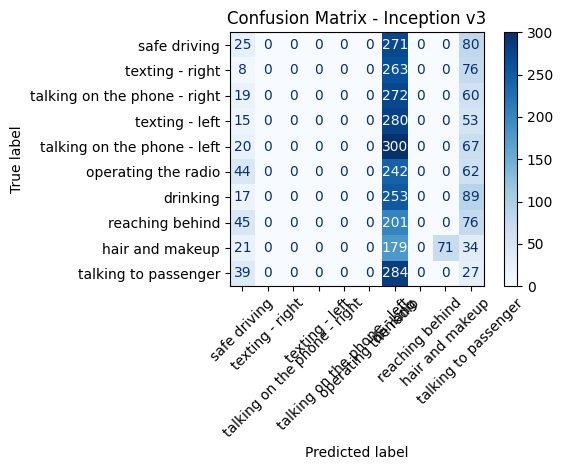

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Get the main output if auxiliary logits are present
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Inception v3")
plt.tight_layout()
plt.show()


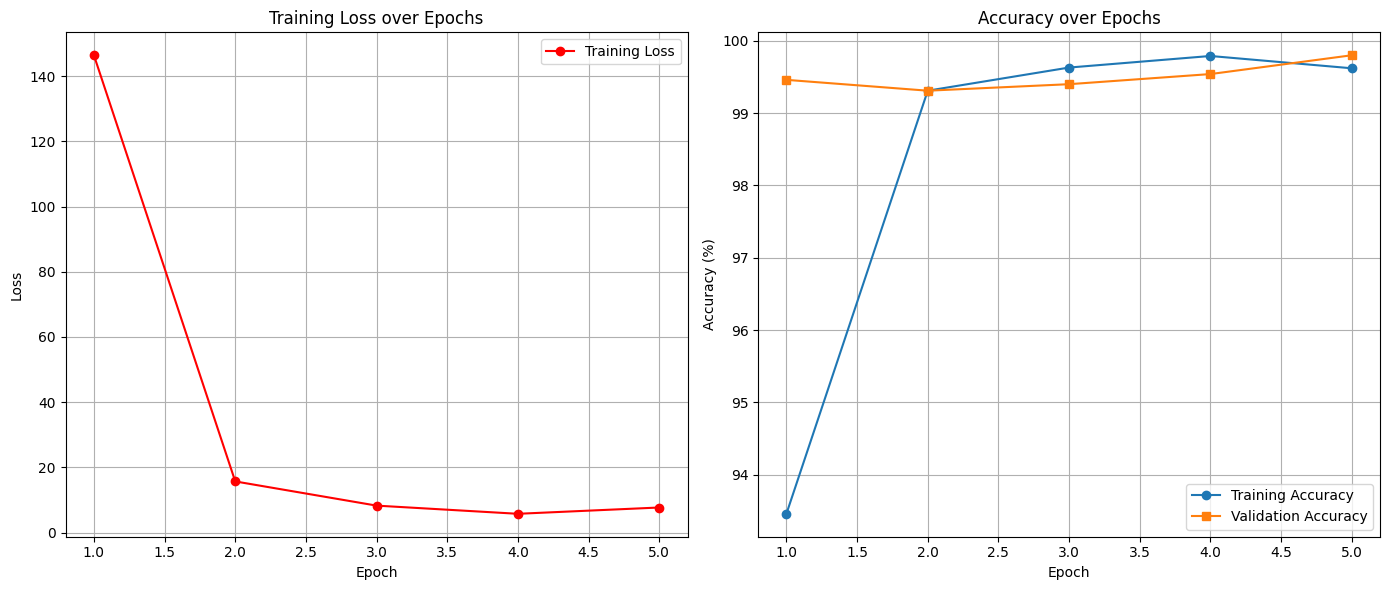

In [ ]:
import matplotlib.pyplot as plt

# Cleaned training results (last loss & last val accuracy removed)
train_losses = [146.440, 15.678, 8.254, 5.746, 7.677]
train_accuracies = [93.46, 99.31, 99.63, 99.79, 99.62]
val_accuracies = [99.46, 99.31, 99.40, 99.54, 99.80]

epochs = range(1, len(train_losses) + 1)  # [1,2,3,4]

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='red', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='s', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
